In [78]:
import os
import os.path
import numpy as np
import datetime
import matplotlib.pyplot as plt

import sys
sys.path.append("..")
import pandas as pd

In [86]:
#Handle data
market_simulator = pd.read_csv(
    '/Users/oscarpeyron/Downloads/012_Quick_Acess/S&P500_index1Y.csv',
    parse_dates=['Datum'],  # Parse 'Datum' as datetime
    index_col='Datum'       # Set 'Datum' as the index
).dropna()


market_simulator["Average_SP_Index"] = (market_simulator["Hoch"] + market_simulator["Tief"]) / 2

market_av = market_simulator["Average_SP_Index"]
market_av = market_av.pct_change().dropna()
market_returns = (market_av - market_av.mean()) / market_av.std()


market = market_simulator["Average_SP_Index"]

#invert the data
market = market.iloc[::-1]
market_returns = market_returns.iloc[::-1]

print(market_returns)
print(market)

Datum
2020-01-29    0.583574
2020-01-30    0.512666
2020-01-31   -0.063601
2020-02-03   -1.181020
2020-02-04   -0.884376
                ...   
2025-01-21   -0.898235
2025-01-22   -0.088685
2025-01-23   -0.144223
2025-01-24    1.950084
2025-01-27   -0.670901
Name: Average_SP_Index, Length: 1256, dtype: float64
Datum
2020-01-29    3282.680
2020-01-30    3264.355
2020-01-31    3248.505
2020-02-03    3252.050
2020-02-04    3293.765
                ...   
2025-01-22    6088.470
2025-01-23    6096.700
2025-01-24    6108.460
2025-01-27    5990.045
2025-01-28    6034.585
Name: Average_SP_Index, Length: 1257, dtype: float64


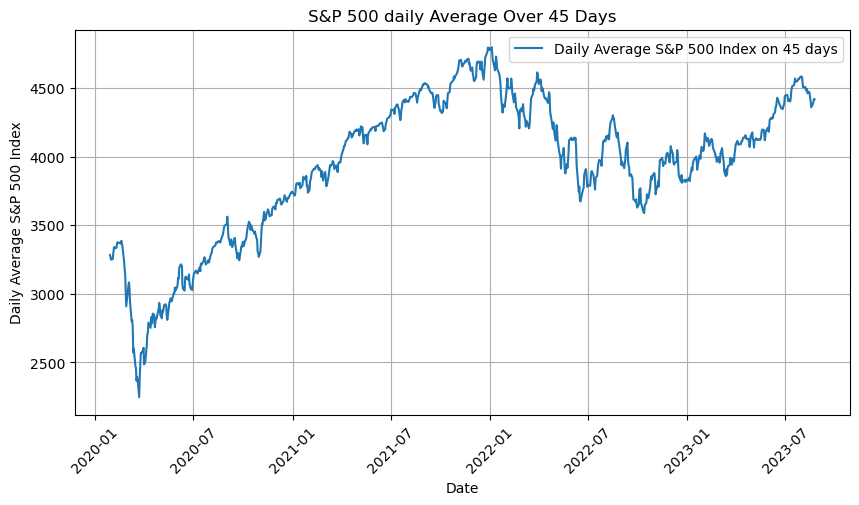

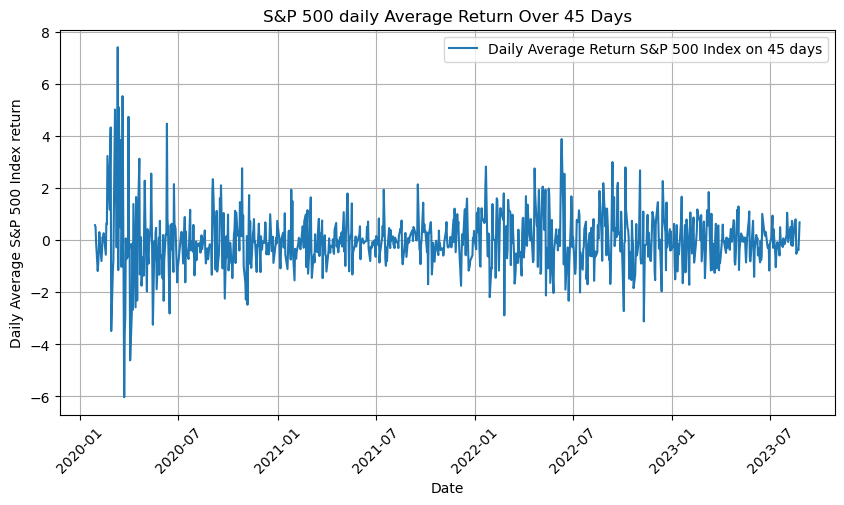

In [163]:
t = 0
T = 900
market_plot = market[t:T]
market_return_plot = market_returns[t:T]

# Plot market
plt.figure(figsize=(10, 5))
plt.plot(market_plot.index, market_plot.values, linestyle='-', label=f"Daily Average S&P 500 Index on {delta_t} days")
# Formatting
plt.xlabel("Date")
plt.ylabel("Daily Average S&P 500 Index")
plt.title(f"S&P 500 daily Average Over {delta_t} Days")
plt.xticks(rotation=45)  # Rotate dates for readability
plt.grid(True)
plt.legend()

#Plot market returns 
plt.figure(figsize=(10, 5))
plt.plot(market_return_plot.index, market_return_plot.values, linestyle='-', label=f"Daily Average Return S&P 500 Index on {delta_t} days")

#Formatting
plt.xlabel("Date")
plt.ylabel("Daily Average S&P 500 Index return")
plt.title(f"S&P 500 daily Average Return Over {delta_t} Days")
plt.xticks(rotation=45)  # Rotate dates for readability
plt.grid(True)
plt.legend()

plt.show()

In [165]:
import numpy as np
import random


def emv_portfolio_selection(
    market_simulator, learning_rates, initial_wealth, target_payoff, 
    investment_horizon, discretization_dt, exploration_rate, 
    num_iterations, sample_average_size, interest_rate
):
    # Extract parameters
    alpha, eta_gamma, eta_phi = learning_rates
    x_0 = initial_wealth  
    z = target_payoff
    T, delta_t = investment_horizon, discretization_dt
    lamb = exploration_rate
    M = num_iterations
    N = sample_average_size
    r= interest_rate

    #initialization of parameters (tuning as best as possible)
    phi = [0,0.1]
    gamma= [-(x_0-z)**2,0,0,2*phi[1]]
    w= x_0

    phi_policy = phi
    
    print("Initial values:")
    print("w =", w)
    print("gamma =", gamma)
    print("phi =", phi)
    D_final = []
    pay_off_mean = []
    pay_off_mean_non_agg = []
    variance_off_sample = []

    for k in range(1, M + 1):
        D = [(0, x_0)]  # Collected samples as tuples (time, wealth)
        for i in range(1, int(T / delta_t)):

            #simulate the market
            t_k, x_k = simulate_market(market_simulator,phi_policy, D, w, T, lamb,delta_t,r)

            #sample collection
            D.append((t_k, x_k))

            # Compute Bellman error
            delta_t_error = compute_bellman_error(gamma, phi, D, w, T, lamb, delta_t)
            
            # Compute gradients (Equations 48-51)
            grad_gamma_1 = compute_grad_gamma_1(gamma, phi, D, w, T, lamb, delta_t)
            grad_gamma_2 = compute_grad_gamma_2(gamma, phi, D, w, T, lamb, delta_t)
            grad_phi_1   = compute_grad_phi_1(gamma, phi, D, w, T, lamb, delta_t)
            grad_phi_2   = compute_grad_phi_2(gamma, phi, D, w, T, lamb, delta_t)

            # Update parameters
            gamma[1] -= eta_gamma * grad_gamma_1
            gamma[2] -= eta_gamma * grad_gamma_2

            # Update gamma[3] and gamma[0] explicitly
            gamma[3] = 2 * phi[1]      # gamma₃ = 2φ₂
            gamma[0] = -gamma[2] * T**2 - gamma[1] * T - (w - z)**2

            #update phi
            phi[0]   -= eta_phi * grad_phi_1
            phi[1]   -= eta_phi * grad_phi_2
        
        #update the policy_phi
        phi_policy[0] = phi[0]
        phi_policy[1] = phi[1]

        #get all the values of x^j_{T/delta} for j in 1 to M 
        D_final.append(D[-1][1])     

        # Update Lagrange multiplier every N iterations (Equation 52)
        if k % N == 0:
            
            #to plot aggregated mean
            pay_off_mean.append(np.mean([x for x in D_final]))


            recent_samples = D_final[k-N+1:k+1] 
            average_terminal_wealth = np.mean([x for x in recent_samples])
            
            #to plot variance and mean over sample size
            variance = sum([(x-average_terminal_wealth)**2 for x in recent_samples])
            pay_off_mean_non_agg.append(average_terminal_wealth)
            variance_off_sample.append(variance)

            #update of the Lagrange mutiplier omega 
            w -= alpha * (average_terminal_wealth - target_payoff)

    return gamma, phi, w, pay_off_mean, pay_off_mean_non_agg, variance_off_sample

def policy_phi(phi_policy, x,t, T,w, lamb):
    mean = -np.sqrt(2 * phi_policy[1] / (lamb * np.pi))* np.exp((2*phi_policy[0]-1)/2) * ((x - w))  
    #print("mean", mean)
    variance = (1 / (2 * np.pi)) * np.exp(2 * phi_policy[1]* (T-t) +  (2 * phi_policy[0] - 1))
    #print(variance)
    return np.random.normal(mean,variance)

def simulate_market(market_simulator, phi_policy, D, w, T, lamb, delta_t,r):
    """Simulates the market and returns sampled (t_k, x_k)."""
    t_k, x_k = D[-1] #get the last sample
    policy = policy_phi(phi_policy, x_k, t_k, T,w,lamb)
   
   #market return going in 
    dx = market_simulator[int((1/delta_t)*t_k + 1)] #change when going to t_k+1
    bank_acc = (1- policy)*x_k*(1+r*1/365) #bank account becomes this with yearly interest of r 
    risky_ass = (1+dx)*x_k*policy #put the allocated asset in risky and observe how it changes
    x_k = bank_acc + risky_ass #observe x_(k+1) with allocation u_i = policy 

    t_k  += delta_t
    return t_k, x_k

def compute_bellman_error(gamma, phi, D, w, T, lamb, delta_t):
    """Computes the Bellman error δ_t (Equation 43)."""
    C = 0 
    for i in range(len(D) - 1):
        t_i   = D[i][0]
        t_i_1 = D[i + 1][0]  # next time step
        x_i   = D[i][1]
        x_i_1 = D[i + 1][1]
        V_t   = compute_V(gamma, phi, x_i, w, t_i, T)
        V_t_1 = compute_V(gamma, phi, x_i_1, w, t_i_1, T)
        V_dot = (V_t_1 - V_t) / delta_t 
        entropy = phi[0] + phi[1] * (T - t_i)
        C += (V_dot - lamb * entropy)**2 * delta_t
    return C / 2

def compute_V(gamma, phi, x, w, t, T):
    arg = -gamma[3] * (T - t)
    V_gamma = (x - w)**2 * np.exp(arg) + gamma[2] * t**2 + gamma[1] * t + gamma[0]
    return V_gamma

def compute_grad_gamma_1(gamma, phi, D, w, T, lamb, delta_t):
    """Computes gradient of cost with respect to θ₁ (Equation 48)."""
    C = 0 
    for i in range(len(D) - 1):
        t_i   = D[i][0]
        t_i_1 = D[i + 1][0]
        x_i   = D[i][1]
        x_i_1 = D[i + 1][1]
        V_t   = compute_V(gamma, phi, x_i, w, t_i, T)
        V_t_1 = compute_V(gamma, phi, x_i_1, w, t_i_1, T)
        V_dot = (V_t_1 - V_t) / delta_t 
        entropy = phi[0] + phi[1] * (T - t_i)
        C += (V_dot - lamb * entropy) *delta_t  
    return C

def compute_grad_gamma_2(gamma, phi, D, w, T, lamb, delta_t):
    """Computes gradient of cost with respect to θ₂ (Equation 49)."""
    C = 0 
    for i in range(len(D) - 1):
        t_i   = D[i][0]
        t_i_1 = D[i + 1][0]
        x_i   = D[i][1]
        x_i_1 = D[i + 1][1]
        V_t   = compute_V(gamma, phi, x_i, w, t_i, T)
        V_t_1 = compute_V(gamma, phi, x_i_1, w, t_i_1, T)
        V_dot = (V_t_1 - V_t) / delta_t 
        entropy = phi[0] + phi[1] * (T - t_i)
        C += (V_dot - lamb * entropy) * (t_i_1**2 - t_i**2)
    return C

def compute_grad_phi_1(gamma, phi, D, w, T, lamb, delta_t):
    """Computes gradient of cost with respect to φ₁ (Equation 50)."""
    C = 0 
    for i in range(len(D) - 1):
        t_i   = D[i][0]
        t_i_1 = D[i + 1][0]
        x_i   = D[i][1]
        x_i_1 = D[i + 1][1]
        V_t   = compute_V(gamma, phi, x_i, w, t_i, T)
        V_t_1 = compute_V(gamma, phi, x_i_1, w, t_i_1, T)
        V_dot = (V_t_1 - V_t) /delta_t
        entropy = phi[0] + phi[1] * (T - t_i)
        C += (-lamb) * (V_dot - lamb * entropy) * delta_t
    return C

def compute_grad_phi_2(gamma, phi, D, w, T, lamb, delta_t):
    """Computes gradient of cost with respect to φ₂ (Equation 51)."""
    C = 0 
    for i in range(len(D) - 1):
        t_i   = D[i][0]
        t_i_1 = D[i + 1][0]
        x_i   = D[i][1]
        x_i_1 = D[i + 1][1]
        V_t   = compute_V(gamma, phi, x_i, w, t_i, T)
        V_t_1 = compute_V(gamma, phi, x_i_1, w, t_i_1, T)
        V_dot = (V_t_1 - V_t) / delta_t  
        entropy = phi[0] + phi[1] * (T - t_i)
        arg1 = -2 * phi[1] * (T - t_i_1)
        arg2 = -2 * phi[1] * (T - t_i)
        exp_factor_1 = np.exp(arg1)
        exp_factor_2 = np.exp(arg2)
        
        gradient_term = (2 * (x_i_1 - w)**2 * exp_factor_1 * (T - t_i_1) -
                         2 * (x_i - w)**2 * exp_factor_2 * (T - t_i)) / 1

        C += (V_dot - lamb * entropy) *  (gradient_term - lamb * (T - t_i)) * delta_t 
    
    return C


Initial values:
w = 0.7
gamma = [-0.022500000000000006, 0, 0, 0.2]
phi = [0, 0.1]
For Market Scenario 1
Final Parameters:
Gamma: [-0.03535805928303882, 0.0054590260468174905, 0.0007194285480757441, 0.1611807770243977]
Phi: [-0.016377078140452323, 0.08059031446919063]
w: 1.0217745350924947
Initial values:
w = 0.7
gamma = [-0.022500000000000006, 0, 0, 0.2]
phi = [0, 0.1]
For Market Scenario 2
Final Parameters:
Gamma: [-0.24348116535750183, 0.0065456138438262194, 0.007643534531230202, 0.1716958697202736]
Phi: [-0.01963684153147906, 0.08584770004665214]
w: 1.3297408325247577


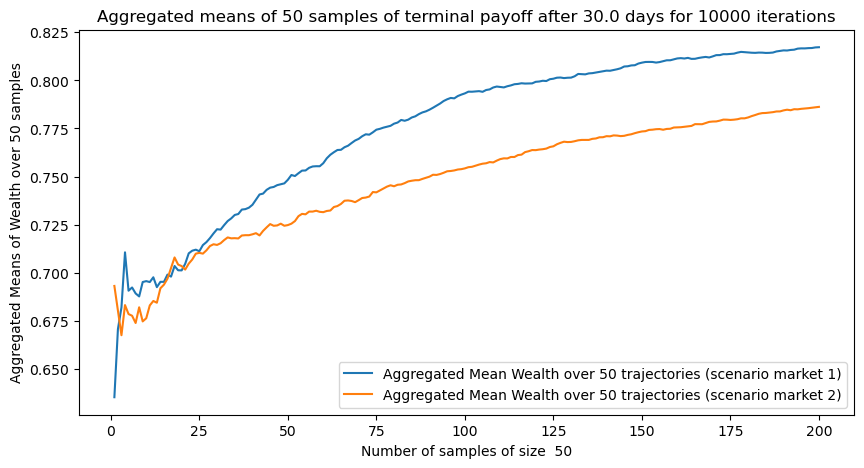

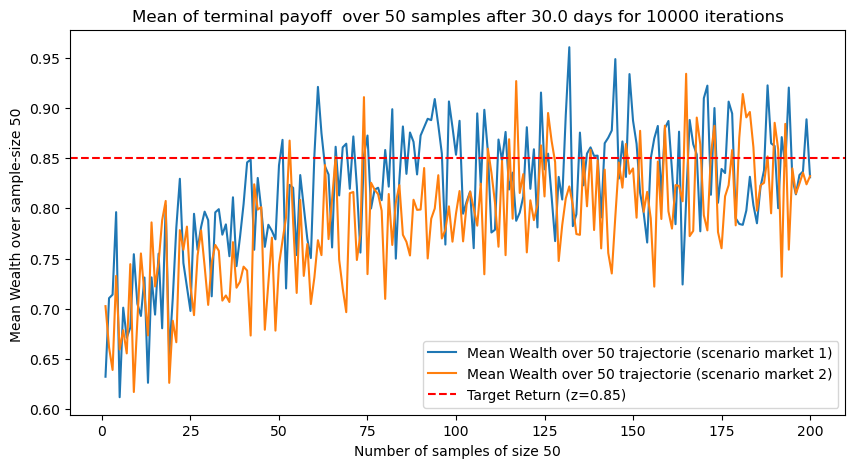

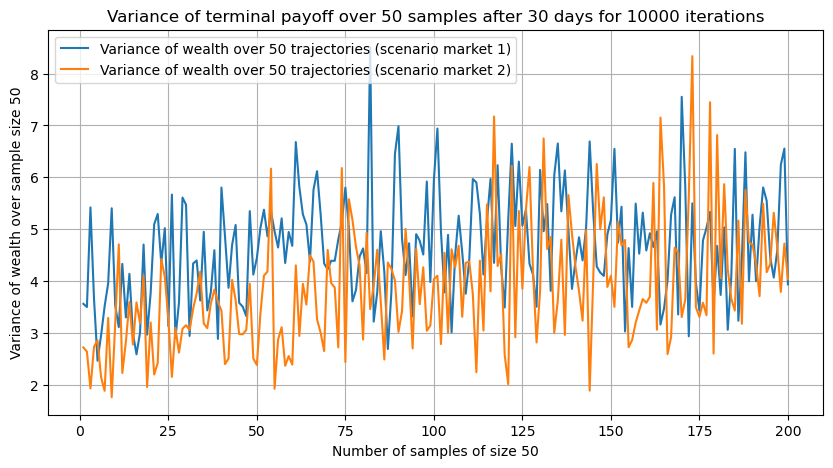

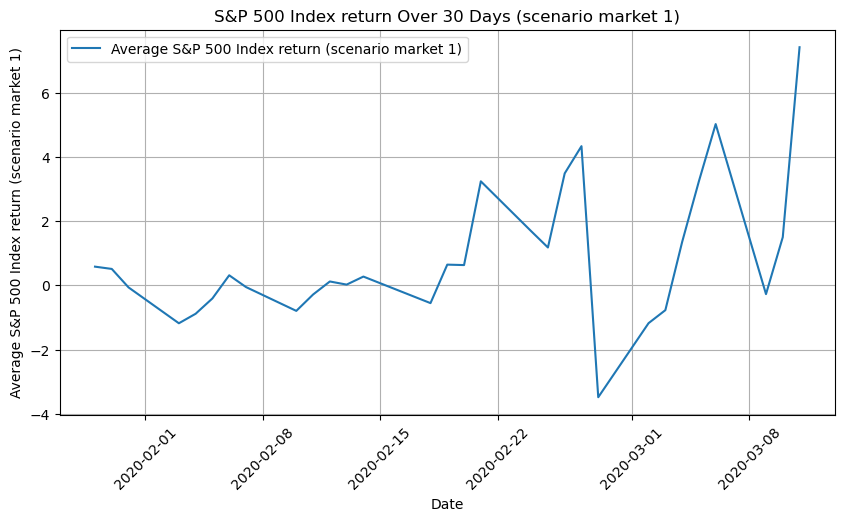

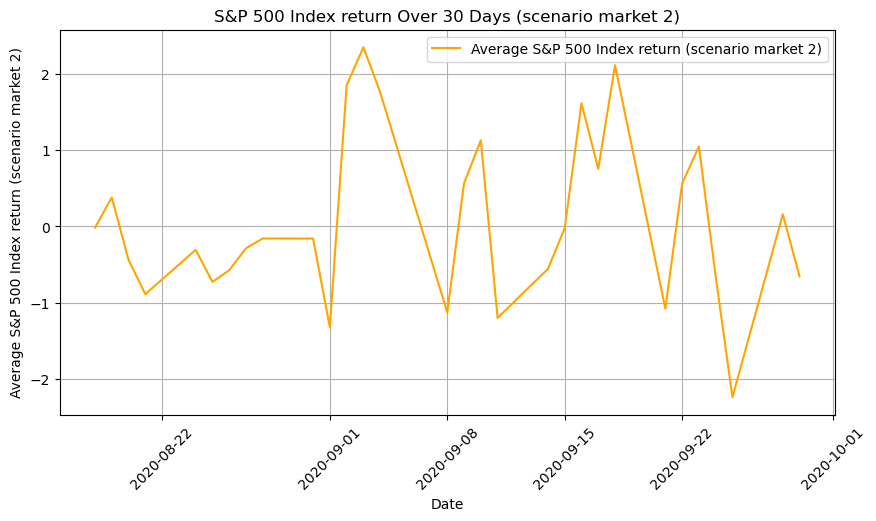

In [168]:
#Market Scenario 1 

# Hyperparameter tunning ----------------------------------------------------------
learning_rates = (0.05, 0.0000005, 0.0000005)   # (alpha, eta_gamma, eta_phi)
exploration_rate = 3 #lambda
num_iterations = 10000
sample_average_size = 50


#Market and Target parameters
initial_wealth = 0.7
target_payoff = 0.85
investment_horizon = 1
discretization_dt = 1/30 #number of days
interest_rate = 0.02
t=0
T = 40 # (delta_t) >= 1/discretization_dt !!!!!
market_return_plot_1 = market_returns[t:T]


#calling the function --------------------------------------------------------------
gamma, phi, w, payoff_mean_1, pay_off_mean_non_agg_1, variance_off_sample_1 = emv_portfolio_selection(
    market_return_plot_1, learning_rates, initial_wealth, target_payoff, 
    investment_horizon, discretization_dt, exploration_rate, 
    num_iterations, sample_average_size, interest_rate
)

print("For Market Scenario 1")
print("Final Parameters:")
print("Gamma:", gamma)
print("Phi:", phi)
print("w:", w)


#Market Scenario 2

# Hyperparameter tunning ----------------------------------------------------------
learning_rates = (0.05, 0.0000005, 0.0000005)  # (alpha, eta_gamma, eta_phi)
exploration_rate = 3 #lambda
num_iterations = 10000
sample_average_size = 50


#Market and Target parameters
initial_wealth = 0.7
target_payoff = 0.85
investment_horizon = 1
discretization_dt = 1/30 #number of days
interest_rate = 0.02
t= 140
T = 180
market_return_plot_2 = market_returns[t:T]

gamma, phi, w, payoff_mean_2, pay_off_mean_non_agg_2, variance_off_sample_2 = emv_portfolio_selection(
    market_return_plot_2, learning_rates, initial_wealth, target_payoff, 
    investment_horizon, discretization_dt, exploration_rate, 
    num_iterations, sample_average_size, interest_rate
)


print("For Market Scenario 2")
print("Final Parameters:")
print("Gamma:", gamma)
print("Phi:", phi)
print("w:", w)

#--------------------------------------------Aggregated mean over the sample_average_size------------------------------------------------------------#
#PLOT Mean payoff

num_trajectories = list(range(1, len(payoff_mean_1) + 1))  # X-axis: trajectory indices

plt.figure(figsize=(10, 5))

plt.plot(num_trajectories, payoff_mean_1, linestyle='-', label=f'Aggregated Mean Wealth over {sample_average_size} trajectories (scenario market 1)')
plt.plot(num_trajectories, payoff_mean_2, linestyle='-', label=f'Aggregated Mean Wealth over {sample_average_size} trajectories (scenario market 2)')


plt.xlabel(f"Number of samples of size  {int(sample_average_size)}")
plt.ylabel(f"Aggregated Means of Wealth over {int(sample_average_size)} samples")
plt.title(f"Aggregated means of {int(sample_average_size)} samples of terminal payoff after {1/discretization_dt} days for {num_iterations} iterations")
plt.legend()

#--------------------------------------------Non aggregated mean over the sample_average_size------------------------------------------------------------#

#PLOT Mean payoff

num_trajectories = list(range(1, len(pay_off_mean_non_agg_1) + 1))  # X-axis: trajectory indices

plt.figure(figsize=(10, 5))

plt.plot(num_trajectories, pay_off_mean_non_agg_1, linestyle='-', label=f'Mean Wealth over {sample_average_size} trajectorie (scenario market 1)')
plt.plot(num_trajectories, pay_off_mean_non_agg_2, linestyle='-', label=f'Mean Wealth over {sample_average_size} trajectorie (scenario market 2)')

plt.axhline(y=target_payoff, color='r', linestyle='--', label=f'Target Return (z={target_payoff})')

plt.xlabel(f"Number of samples of size {int(sample_average_size)}")
plt.ylabel(f"Mean Wealth over sample-size {int(sample_average_size)} ")
plt.title(f"Mean of terminal payoff  over {int(sample_average_size)} samples after {1/discretization_dt} days for {num_iterations} iterations")
plt.legend()


#--------------------------------------------Variance over the sample_average_size------------------------------------------------------------#

#PLOT Mean payoff

num_trajectories_bear = list(range(1, len(variance_off_sample_1) + 1))
num_trajectories_bull = list(range(1, len(variance_off_sample_2) + 1))

plt.figure(figsize=(10, 5))

plt.plot(num_trajectories_bear, variance_off_sample_1, linestyle='-', label=f'Variance of wealth over {sample_average_size} trajectories (scenario market 1)')
plt.plot(num_trajectories_bull, variance_off_sample_2, linestyle='-', label=f'Variance of wealth over {sample_average_size} trajectories (scenario market 2)')


plt.xlabel(f"Number of samples of size {int(sample_average_size)}")
plt.ylabel(f"Variance of wealth over sample size {int(sample_average_size)}")
plt.title(f"Variance of terminal payoff over {int(sample_average_size)} samples after {int(1/discretization_dt)} days for {num_iterations} iterations")
plt.legend()
plt.grid(True)  # Improves readability
plt.show()

#-------------------------------------S&P 500 plotting---------------------------------------------------------------------------------------------#


#Market scenario 1 
market_av_30 = market_return_plot_1[:int(1/discretization_dt)]

# Plot
plt.figure(figsize=(10, 5))
plt.plot(market_av_30.index, market_av_30.values, linestyle='-', label="Average S&P 500 Index return (scenario market 1)")

# Formatting
plt.xlabel("Date")
plt.ylabel("Average S&P 500 Index return (scenario market 1)")
plt.title(f"S&P 500 Index return Over {int(1/discretization_dt)} Days (scenario market 1)")
plt.xticks(rotation=45)  # Rotate dates for readability
plt.grid(True)
plt.legend()
plt.show()

#Market scenario 2
market_av_30 = market_return_plot_2[:int(1/discretization_dt)]

# Plot
plt.figure(figsize=(10, 5))
plt.plot(market_av_30.index, market_av_30.values, linestyle='-', label="Average S&P 500 Index return (scenario market 2)", color = "orange")

# Formatting
plt.xlabel("Date")
plt.ylabel("Average S&P 500 Index return (scenario market 2)")
plt.title(f"S&P 500 Index return Over {int(1/discretization_dt)} Days (scenario market 2)")
plt.xticks(rotation=45)  # Rotate dates for readability
plt.grid(True)
plt.legend()
plt.show()

In [164]:
#Market Scenario 3

#Tuning hyperparameters

# Hyperparameter tunning ----------------------------------------------------------
learning_rates = (0.05, 0.00005, 0.00005)  # (alpha, eta_gamma, eta_phi)
exploration_rate = 2 #lambda
num_iterations = 10000
sample_average_size = 50


#Market and Target parameters
initial_wealth = 0.7
target_payoff = 0.85
investment_horizon = 1
discretization_dt = 1/30 #number of days
interest_rate = 0.02
t = 370
T = 410
market_return_plot_3 = market_returns[t:T]

gamma, phi, w, payoff_mean_3, pay_off_mean_non_agg_3, variance_off_sample_3 = emv_portfolio_selection(
    market_return_plot_3, learning_rates, initial_wealth, target_payoff, 
    investment_horizon, discretization_dt, exploration_rate, 
    num_iterations, sample_average_size, interest_rate
)


print("For Market Scenario 3")
print("Final Parameters:")
print("Gamma:", gamma)
print("Phi:", phi)
print("w:", w)

#--------------------------------------------Aggregated mean over the sample_average_size------------------------------------------------------------#
#PLOT Mean payoff

num_trajectories = list(range(1, len(payoff_mean_3) + 1))  # X-axis: trajectory indices

plt.figure(figsize=(10, 5))


plt.plot(num_trajectories, payoff_mean_3, linestyle='-', label=f'Aggregated Mean Wealth over {sample_average_size} trajectories (scenario market 3)')


plt.xlabel(f"Aggregated means of {int(sample_average_size)} samples of terminal payoff after {1/discretization_dt} days for {num_iterations} iterations")
plt.ylabel(f"Aggregate means of (x_T) with T={int(1/discretization_dt)} days")
plt.title(f"Aggregated Means of Wealth over {int(sample_average_size)} samples")
plt.legend()

#--------------------------------------------Non aggregated mean over the sample_average_size------------------------------------------------------------#

#PLOT Mean payoff

num_trajectories = list(range(1, len(pay_off_mean_non_agg_3) + 1))  # X-axis: trajectory indices

plt.figure(figsize=(10, 5))


plt.plot(num_trajectories, pay_off_mean_non_agg_3, linestyle='-', label=f'Mean Wealth over {sample_average_size} trajectorie (scenario market 3)')


plt.axhline(y=target_payoff, color='r', linestyle='--', label=f'Target Return (z={target_payoff})')

plt.xlabel(f"Mean of terminal payoff  over {int(sample_average_size)} samples after {1/discretization_dt} days for {num_iterations} iterations")
plt.ylabel(f"Means of (x_T) over sample size with T={int(1/discretization_dt)} days")
plt.title(f"Mean Wealth vs. {int(sample_average_size)} samples")
plt.legend()


#--------------------------------------------Variance over the sample_average_size------------------------------------------------------------#

#PLOT Mean payoff

num_trajectories_bull = list(range(1, len(variance_off_sample_3) + 1))

plt.figure(figsize=(10, 5))


plt.plot(num_trajectories_bull, variance_off_sample_3, linestyle='-', label=f'Variance of wealth over {sample_average_size} trajectories (scenario market 3)')


plt.xlabel(f"Variance of terminal payoff over {int(sample_average_size)} samples after {int(1/discretization_dt)} days for {num_iterations} iterations")
plt.ylabel(f"Variance (x_T) with T= {int(1/discretization_dt)} days")
plt.title(f"Variance of wealth vs. Number of samples {int(sample_average_size)}")
plt.legend()
plt.grid(True)  # Improves readability
plt.show()


#Market scenario 3
market_av_30 = market_return_plot_3[:int(1/discretization_dt)]

# Plot
plt.figure(figsize=(10, 5))
plt.plot(market_av_30.index, market_av_30.values, linestyle='-', label="Average S&P 500 Index return (scenario market 3)", color = "green")

# Formatting
plt.xlabel("Date")
plt.ylabel("Average S&P 500 Index return (scenario market 3)")
plt.title(f"S&P 500 Index return Over {int(1/discretization_dt)} Days (scenario market 3)")
plt.xticks(rotation=45)  # Rotate dates for readability
plt.grid(True)
plt.legend()
plt.show()


Initial values:
w = 0.7
gamma = [-0.022500000000000006, 0, 0, 0.2]
phi = [0, 0.1]


KeyboardInterrupt: 